<a href="https://colab.research.google.com/github/XUANHAOC/DASC6510F2023Project/blob/main/NNAR%2BXvariable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/ETTh1.csv')
df.head()


import numpy as np


for lag in range(1, 26):
    df[f'lag_{lag}'] = df['OT'].shift(lag)

# 删除由于创建滞后特征而产生的缺失值行
df.dropna(inplace=True)

# 计算训练集和测试集的分割点
split_index = int(len(df) * 0.95)

# 分割训练集和测试集
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# 从训练集和测试集中提取NNAR和MLP的输入
train_nnar_inputs = train_df[[f'lag_{i}' for i in range(1, 26)]]
train_mlp_inputs = train_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']]
train_targets = train_df['OT']

test_nnar_inputs = test_df[[f'lag_{i}' for i in range(1, 26)]]
test_mlp_inputs = test_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']]
test_targets = test_df['OT']


In [10]:
train_nnar_inputs.head

<bound method NDFrame.head of            lag_1      lag_2      lag_3      lag_4      lag_5      lag_6  \
25     21.104000  19.768000  18.009001  18.009001  17.868000  18.712000   
26     19.697001  21.104000  19.768000  18.009001  18.009001  17.868000   
27     20.049000  19.697001  21.104000  19.768000  18.009001  18.009001   
28     20.752001  20.049000  19.697001  21.104000  19.768000  18.009001   
29     21.385000  20.752001  20.049000  19.697001  21.104000  19.768000   
...          ...        ...        ...        ...        ...        ...   
16545   6.050000   5.979000   5.909000   6.050000   5.698000   5.628000   
16546   6.472000   6.050000   5.979000   5.909000   6.050000   5.698000   
16547   6.402000   6.472000   6.050000   5.979000   5.909000   6.050000   
16548   6.402000   6.402000   6.472000   6.050000   5.979000   5.909000   
16549   6.753000   6.402000   6.402000   6.472000   6.050000   5.979000   

           lag_7      lag_8      lag_9     lag_10  ...     lag_16    

In [11]:
test_nnar_inputs.head

<bound method NDFrame.head of         lag_1   lag_2   lag_3   lag_4   lag_5  lag_6  lag_7  lag_8  lag_9  \
16550   7.105   6.753   6.402   6.402   6.472  6.050  5.979  5.909  6.050   
16551   7.175   7.105   6.753   6.402   6.402  6.472  6.050  5.979  5.909   
16552   7.316   7.175   7.105   6.753   6.402  6.402  6.472  6.050  5.979   
16553   5.628   7.316   7.175   7.105   6.753  6.402  6.402  6.472  6.050   
16554   4.432   5.628   7.316   7.175   7.105  6.753  6.402  6.402  6.472   
...       ...     ...     ...     ...     ...    ...    ...    ...    ...   
17415  10.200   9.426   9.215   9.215   8.934  9.075  9.426  9.638  9.286   
17416  10.904  10.200   9.426   9.215   9.215  8.934  9.075  9.426  9.638   
17417  11.044  10.904  10.200   9.426   9.215  9.215  8.934  9.075  9.426   
17418  10.271  11.044  10.904  10.200   9.426  9.215  9.215  8.934  9.075   
17419   9.778  10.271  11.044  10.904  10.200  9.426  9.215  9.215  8.934   

       lag_10  ...  lag_16  lag_17  lag_18  l

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error




# 转换为Numpy数
X_train = train_mlp_inputs.to_numpy()
y_train = train_targets.to_numpy()

# 定义MLPRegressor
mlp = MLPRegressor(max_iter=200)

# 定义要测试的参数网格
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# 使用GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train.ravel())

# 打印最佳参数集
print('Best parameters found:\n', clf.best_params_)

# 在训练集上进行预测
y_pred = clf.predict(X_train)

# 计算均方误差
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error on training set:", mse)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
Mean Squared Error on training set: 47.192298220605274


In [11]:
from torch.utils.data import TensorDataset, DataLoader

# 假设 train_nnar_inputs, train_mlp_inputs 和 train_targets 已经是Pandas DataFrame或者Series
# 首先将它们转换为PyTorch张量
train_nnar_inputs_tensor = torch.tensor(train_nnar_inputs.values, dtype=torch.float32)
train_mlp_inputs_tensor = torch.tensor(train_mlp_inputs.values, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets.values, dtype=torch.float32).view(-1, 1)

# 创建TensorDataset
train_dataset = TensorDataset(train_nnar_inputs_tensor, train_mlp_inputs_tensor, train_targets_tensor)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)




In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
num_epochs = 200

class NNARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNARModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x


class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)  # 隐藏层维度为100
        self.relu = nn.ReLU()  # 使用ReLU激活函数
        self.fc2 = nn.Linear(100, 1)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  # 应用ReLU激活函数
        x = self.fc2(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, nnar_model, mlp_model):
        super(CombinedModel, self).__init__()
        self.nnar_model = nnar_model
        self.mlp_model = mlp_model
        self.fc = nn.Linear(2, 1)

    def forward(self, nnar_input, mlp_input):
        nnar_output = self.nnar_model(nnar_input)
        mlp_output = self.mlp_model(mlp_input)
        combined = torch.cat((nnar_output, mlp_output), dim=1)
        x = self.fc(combined)
        return x

x_dim = train_mlp_inputs.shape[1]
# 实例化模型
nnar_model = NNARModel(input_dim=25, hidden_dim=13)
mlp_model = MLPModel(input_dim=x_dim)  # 直接使用x_dim
combined_model = CombinedModel(nnar_model, mlp_model)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# 训练过程
for epoch in range(num_epochs):
    for nnar_data, mlp_data, targets in train_loader:
        optimizer.zero_grad()
        combined_output = combined_model(nnar_data, mlp_data)
        loss = criterion(combined_output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/200, Loss: 64.95365142822266
Epoch 2/200, Loss: 33.93109893798828
Epoch 3/200, Loss: 37.460147857666016
Epoch 4/200, Loss: 24.761301040649414
Epoch 5/200, Loss: 11.229588508605957
Epoch 6/200, Loss: 4.312005996704102
Epoch 7/200, Loss: 18.568910598754883
Epoch 8/200, Loss: 2.11942458152771
Epoch 9/200, Loss: 1.218998670578003
Epoch 10/200, Loss: 2.816056728363037
Epoch 11/200, Loss: 1.8491917848587036
Epoch 12/200, Loss: 1.7057024240493774
Epoch 13/200, Loss: 1.809604525566101
Epoch 14/200, Loss: 2.2547178268432617
Epoch 15/200, Loss: 1.2547686100006104
Epoch 16/200, Loss: 2.1642794609069824
Epoch 17/200, Loss: 1.6535576581954956
Epoch 18/200, Loss: 0.6616123914718628
Epoch 19/200, Loss: 0.6753188371658325
Epoch 20/200, Loss: 1.7384577989578247
Epoch 21/200, Loss: 1.1640887260437012
Epoch 22/200, Loss: 0.5617429614067078
Epoch 23/200, Loss: 1.3334743976593018
Epoch 24/200, Loss: 0.4604438245296478
Epoch 25/200, Loss: 2.4791860580444336
Epoch 26/200, Loss: 0.32943016290664673
Ep

In [13]:
# 设置为评估模式
combined_model.eval()

# 不计算梯度
with torch.no_grad():
    # 准备测试数据
    test_nnar_inputs_tensor = torch.tensor(test_nnar_inputs.values, dtype=torch.float32)
    test_mlp_inputs_tensor = torch.tensor(test_mlp_inputs.values, dtype=torch.float32)
    test_targets_tensor = torch.tensor(test_targets.values, dtype=torch.float32).view(-1, 1)

    # 进行预测
    test_predictions = combined_model(test_nnar_inputs_tensor, test_mlp_inputs_tensor)

    # 计算损失
    test_loss = criterion(test_predictions, test_targets_tensor)
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 0.3214495778083801


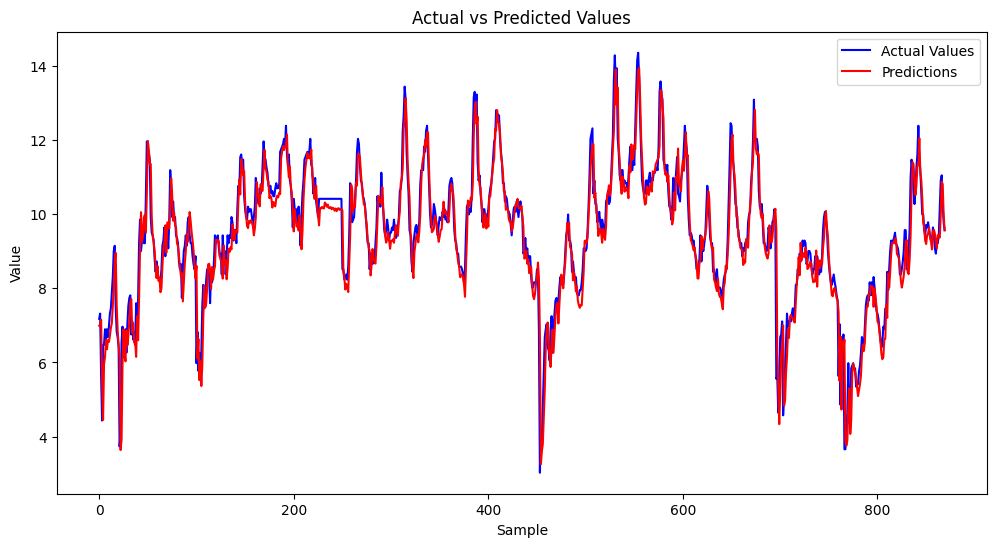

In [20]:
import matplotlib.pyplot as plt

# 确保模型处于评估模式
combined_model.eval()

# 不计算梯度
with torch.no_grad():
    test_predictions = combined_model(test_nnar_inputs_tensor, test_mlp_inputs_tensor)
    test_predictions = test_predictions.numpy()  # 转换为numpy数组

# 获取实际目标值
actual_values = test_targets_tensor.numpy()

# 绘制预测值和实际值
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(test_predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean Error (ME): 2.4038013219833374
Root Mean Squared Error (RMSE): 9.298983832998735
Mean Absolute Error (MAE): 7.642994618415832
Mean Percentage Error (MPE): 35.05065667774199%
Mean Absolute Percentage Error (MAPE): 87.36334905867903%


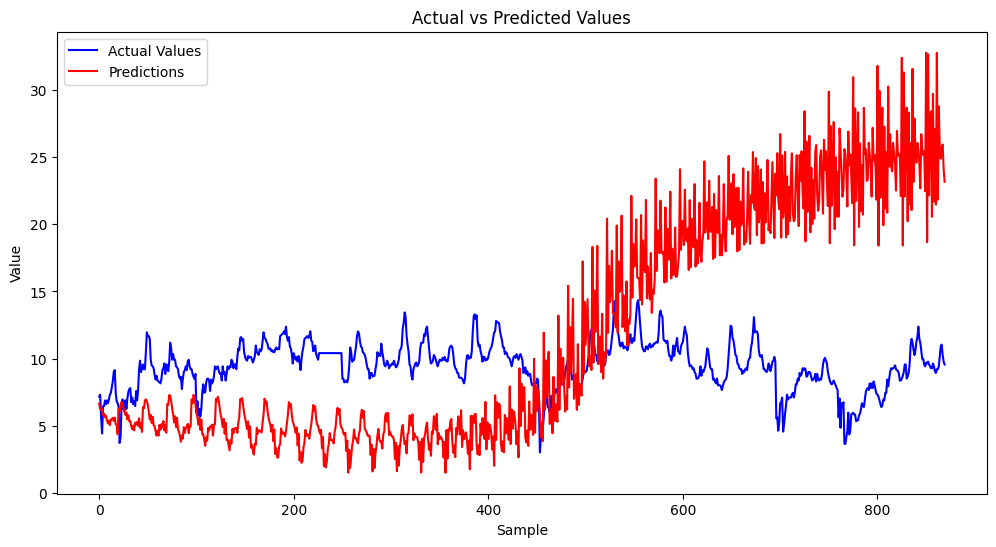

In [19]:
combined_model.eval()

# 从测试集的最后一批数据开始
last_nnar_values = train_nnar_inputs_tensor[-1:]  # 取训练集的最后一个样本作为起点

predictions = []

# 预测测试集的每一步
for _ in range(len(test_targets)):
    with torch.no_grad():
        # 使用combined_model进行预测
        nnar_output = nnar_model(last_nnar_values)
        mlp_output = mlp_model(test_mlp_inputs_tensor[_].unsqueeze(0))
        combined_output = combined_model.fc(torch.cat((nnar_output, mlp_output), dim=1))

        # 将预测值添加到predictions列表
        predictions.append(combined_output.item())

        # 更新last_nnar_values，将新预测加入并移除最早的值
        last_nnar_values = torch.cat((last_nnar_values[:, 1:], combined_output), dim=1)


from sklearn.metrics import mean_squared_error, mean_absolute_error

# ME
me = np.mean(predictions - test_targets.values)

# RMSE
rmse = np.sqrt(mean_squared_error(test_targets.values, predictions))

# MAE
mae = mean_absolute_error(test_targets.values, predictions)

# MPE
mpe = np.mean((predictions - test_targets.values) / test_targets.values) * 100

# MAPE
mape = np.mean(np.abs((predictions - test_targets.values) / test_targets.values)) * 100

# 打印结果
print(f"Mean Error (ME): {me}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Percentage Error (MPE): {mpe}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# 转换predictions为numpy数组以便绘图
predictions = np.array(predictions)

# 绘制预测值和实际值
plt.figure(figsize=(12, 6))
plt.plot(test_targets.values, label='Actual Values', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()
